In [1]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import sys; sys.path.append(3*'../')
from src import *
import matplotlib.pyplot as plt

device = torch.device('cpu') # for second gpu

In [11]:
class ControlledPendulum(nn.Module):
    """
    Inverted pendulum with torsional spring
    """
    def __init__(self, u, m=1., k=.5, l=1., qr=0., β=.01, g=9.81):
        super().__init__()
        self.u = u # controller (nn.Module)
        self.nfe = 0 # number of function evaluations
        self.cur_f = None # current function evaluation
        self.cur_u = None # current controller evaluation 
        self.m, self.k, self.l, self.qr, self.β, self.g = m, k, l, qr, β, g # physics
        
    def forward(self, t, x):
        self.nfe += 1
        q, p = x[..., :1], x[..., 1:]
        self.cur_u = self.u(t, x)
        dq = p/self.m
        dp = -self.k*(q - self.qr) - self.m*self.g*self.l*torch.sin(q) \
            -self.β*p/self.m + self.cur_u
        self.cur_f = torch.cat([dq, dp], -1)
        return self.cur_f

ControlledSystem = ControlledPendulum
def R(X, u, Δt, method, hypereuler=None):
    system = ControlledSystem(RandConstController((1,1), -1, 1))
    system.u.u0 = u
    t_span = torch.tensor([0, Δt]).to(device)
    with torch.no_grad():
        x_fine = odeint(system, X, t_span, method='dopri5')[-1]
        if hypereuler:
            xfu = torch.cat([X, system(0, X), u], -1)
            x_coarse =  X + Δt*system(0, X) + (Δt**2)*hypereuler(xfu)
        else:
            x_coarse = odeint(system, X, t_span, method=method)[-1]
        return torch.norm(x_fine - x_coarse, p=2, dim=-1)

## Compare multiple $\Delta t$

In [4]:
def residual_loss(g, X, u, Δt, method, order=1):
    system = ControlledSystem(RandConstController((1,1), -1, 1))
    system.u.u0 = u    
    t_span = torch.tensor([0, Δt]).to(device)
    x_fine = odeint(system, X, t_span, method='dopri5')[-1]
    x_coarse = odeint(system, X, t_span, method=method)[-1]
    xfu = torch.cat([X, system(0, X), u], -1)
    return torch.norm(x_fine - x_coarse - (Δt**(order+1))*g(xfu), p=2, dim=-1)/(Δt**(order+1))

In [5]:
from tqdm import tqdm

Δt_test = [0.01, 0.03, 0.1, 0.3, 1.0]
hs_list = []

x_min_train, x_max_train = -5, 5
u_lim = 10
bs_hs = 1000
n_grid = 100
megalosses = []

In [8]:

# Train HyperEuler on multiple delta t
for Δt in Δt_test:
    print('Training HyperEuler with Δt = ',Δt, '...')
    hdim = 32
    hs = nn.Sequential(nn.Linear(5, 32), nn.Softplus(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 2)).to(device)
    losses = []
    opt_hs = torch.optim.Adam(hs.parameters(), lr=1e-3)
    '''Hypersolver training loop with given Δt_test'''
    for epoch in tqdm(range(100000)):
        opt_hs.zero_grad()
        # Randomize state and controller values
        x = torch.Tensor(bs_hs, 2).uniform_(x_min_train, x_max_train).to(device)
        #_grid = x.repeat(n_grid, 1, 1).detach()
        u_rand = torch.Tensor(bs_hs, 1).uniform_(-u_lim, u_lim).to(device)
        loss = residual_loss(hs, x[:, None, :], u_rand[:, None, :],  Δt, 'euler').mean()
        # Optimization step
        loss.backward()
        opt_hs.step()
        losses.append(loss.detach().cpu().item())
        # print(f'Step: {epoch}, Residual loss: {loss:.3f}')
    print(f'Residual loss: {loss:.3f}')
    megalosses.append(losses)
    torch.save(hs, f'saved_models/hs{Δt}.pt')
    hs_list.append(hs)

  0%|          | 21/100000 [00:00<08:19, 200.30it/s]

Training HyperEuler with Δt =  0.01 ...


  0%|          | 18/100000 [00:00<09:29, 175.49it/s]

Residual loss: 0.050
Training HyperEuler with Δt =  0.03 ...


  0%|          | 16/100000 [00:00<10:42, 155.50it/s]

Residual loss: 0.078
Training HyperEuler with Δt =  0.1 ...


  0%|          | 10/100000 [00:00<18:03, 92.28it/s]

Residual loss: 0.068
Training HyperEuler with Δt =  0.3 ...


  0%|          | 4/100000 [00:00<48:21, 34.46it/s]

Residual loss: 0.052
Training HyperEuler with Δt =  1.0 ...


100%|██████████| 100000/100000 [50:50<00:00, 32.79it/s]

Residual loss: 0.088


## Comparison plot

In [9]:
hs_list = []
for t in Δt_test:
    hs_list.append(torch.load(f'saved_models/hs{t}.pt'))

In [12]:
import matplotlib.pyplot as plt

n_x, n_u = 10000, 100
x = torch.Tensor(n_x, 2).uniform_(-2, 2).to(device)
qp = torch.linspace(x_min_train, x_max_train, 100) ; Q, P = torch.meshgrid(qp, qp) ; x = torch.cat([Q.reshape(-1, 1), P.reshape(-1, 1)], -1).to(device)
u = torch.linspace(-u_lim, u_lim, n_u)[:,None].to(device)

X = x.repeat(n_u, 1, 1)
U = u.repeat(n_x, 1, 1).permute(1, 0, 2)
X = X.cpu()
U = U.cpu()
res_eu, res_he, res_mp, res_rk, res_dp = [], [], [], [], []

for Δt, i in zip(Δt_test, range(len(Δt_test))):
    res_eu.append(R(X, U, Δt, 'euler').cpu()) 
    res_he.append(R(X, U, Δt, 'euler', hypereuler=hs_list[i].cpu()).cpu())
    res_mp.append(R(X, U, Δt, 'midpoint').cpu())
    res_rk.append(R(X, U, Δt, 'rk4').cpu())
    res_dp.append(R(X, U, Δt, 'dopri5').cpu())
u = u.cpu().squeeze()


In [14]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

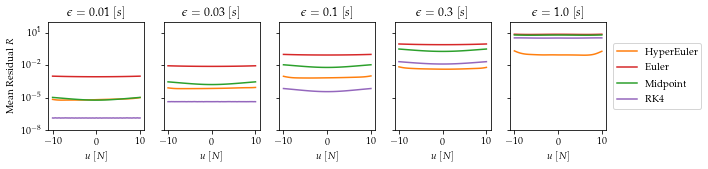

In [42]:


alpha = .1

fig, ax = plt.subplots(1, len(hs_list), figsize=(10, 2))
# plt.tight_layout()

for Δt, i in zip(Δt_test, range(len(Δt_test))):
        # HyperEuler
    ax[i].plot(u, res_he[i].mean(1), label='HyperEuler', color='tab:orange')
    # ax[i].fill_between(u, res_he[i].mean(1) - res_he[i].std(1),
    #                 res_he[i].mean(1) + res_he[i].std(1), alpha=alpha, color='tab:orange')
    ax[i].plot(u, res_eu[i].mean(1), label='Euler', color='tab:red')
    # ax[i].fill_between(u, res_eu[i].mean(1) - res_eu[i].std(1),
    #                 res_eu[i].mean(1) + res_eu[i].std(1), alpha=alpha, color='tab:red')

    ax[i].plot(u, res_mp[i].mean(1), label='Midpoint', color='tab:green')
    # ax[i].fill_between(u, res_mp[i].mean(1) - res_mp[i].std(1),
    #                 res_mp[i].mean(1) + res_mp[i].std(1), alpha=alpha, color='tab:green')
    ax[i].plot(u, res_rk[i].mean(1), label='RK4', color='tab:purple')
    # ax[i].fill_between(u, res_rk[i].mean(1) - res_rk[i].std(1),
    #                 res_rk[i].mean(1) + res_rk[i].std(1), alpha=alpha, color='tab:purple')
#     ax[i].plot(u, res_dp[i].mean(1), label='Dopri5', color='purple')
#     ax[i].fill_between(u, res_dp[i].mean(1) - res_dp[i].std(1),
#                     res_dp[i].mean(1) + res_dp[i].std(1), alpha=alpha, color='purple')
    
    ax[i].set_title(r'$\epsilon = {}~[s]$'.format(Δt))
    ax[i].set_xlabel(r'$u~[N]$')
#     ax[i].legend()
    ax[i].set_yscale('log')
    ax[i].label_outer()
    ax[i].set_ylim([1e-8, 1e2])
    ax[i].set_yticks([1e-8, 1e-5, 1e-2, 1e01])
#     ax[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    
ax[0].set_ylabel(r'Mean Residual $R$')
plt.legend(loc='lower center', ncol=1, bbox_to_anchor=(1.53, 0.15), fancybox=True)
# plt.suptitle('Solver residuals with different step sizes',fontsize=14, weight='semibold', y=1.04)

# ## Saving
import tikzplotlib
fig.savefig('residuals_pendulum_multi_epsilon.pdf',  bbox_inches = 'tight')
tikzplotlib.save("residuals_pendulum_multi_epsilon.tex")